# Computing Simulated Graph

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from  pathlib import Path

PATH_TO_DATA = Path('../data')

In [20]:
def graph_simu_nx(Infects, G):
    graph_sim = nx.DiGraph()

    # initial infected indices
    I_previous = np.where(Infects[:,0]==1)[0]

    for i in I_previous:
        graph_sim.add_node(i)

    # list of elaborated articles indices
    done = list(I_previous)

    for status in Infects[:, 1:]:
        I = list(np.where(status==1)[0])
        I_current = I.copy()
        for article in done:
            if article in I_current:
                I_current.remove(article)

        if len(I_current) == 0:
            continue

        #se temos mais de uma possibilidade de pai
        if len(I_previous) == 1:
            for node in I_current:
                graph_sim.add_edge(I_previous[0], node)
                done.append(node)

        else:
            #calcular pai para cada no que foi infectado
            for node in I_current:
                #pegando a probabilidade de cada no ja infectado ter infectado o no node
                influences = G[node]
                probs = [influences[i] for i in I_previous]

                if sum(probs) != 0 :
                    probs = probs/sum(probs)
                else:
                    # se o no nao foi influenciado por ninguem entao nao pode ser influenciador
                    Infects[node, :] = np.zeros(Infects.shape[1])
                    done.append(node)
                    continue

                pos = np.random.choice(len(probs), 1, p=probs)
                graph_sim.add_edge(I_previous[pos[0]], node)
                done.append(node)
        I_previous = I

    return graph_sim

In [5]:
Infects = np.loadtxt(open(PATH_TO_DATA/'Infects.csv'), delimiter=",")
G = np.loadtxt(open(PATH_TO_DATA/'graph_complete.csv'), delimiter=",")
original_graph = nx.read_gpickle(PATH_TO_DATA/'empirical_graph.gpickle')

In [22]:
ori_outs = [i[1] for i in original_graph.out_degree()]
g_ori = gaussian_kde(ori_outs)

graph_simulated = graph_simu_nx(Infects, G)
nx.write_gpickle(graph_simulated, PATH_TO_DATA/'graph_simulated_nx.gpickle')
sim_outs = [j[1] for j in graph_simulated.out_degree()]
g_sim = gaussian_kde(sim_outs)

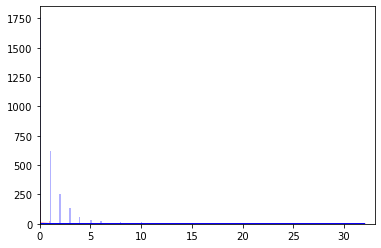

In [34]:
limit = max(np.max(sim_outs), np.max(ori_outs))
plt.hist(sim_outs, bins='auto', color='r', alpha=0.3)#, density=True, stacked=True)
plt.hist(ori_outs, bins='auto', color='b', alpha=0.3)#, density=True, stacked=True)
plt.plot(range(0, limit), g_sim.evaluate(range(limit)), color='r')
plt.plot(range(0, limit), g_ori.evaluate(range(limit)), color='b')
plt.xlim(0, limit)
plt.savefig(PATH_TO_DATA/'graph_validation.png')
plt.show()